## Imported Libraries

In [6]:
# Imported Libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from utils.plot_clusters import plot_clusters
import cmasher as cmr

from utils.visualization import Colors
from utils.matchers import FeatureMatcher

# Images Path
scene_folder = './images/scenes/'
model_folder = './images/models/'

# Single instance detection (Step A)

This section explains the steps that the ``FeatureMatcher`` class performs to find the matching keypoints between the model image and the scene image.

## Read images

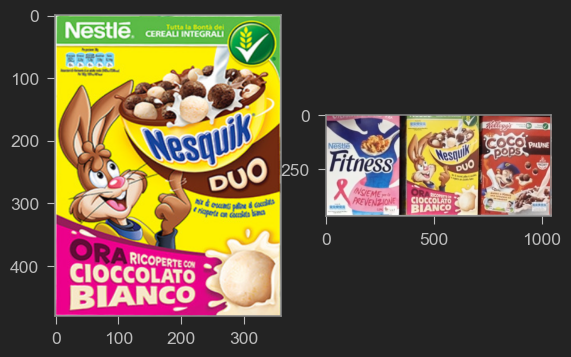

In [24]:
im_scene = cv2.cvtColor(cv2.imread(scene_folder + 'e2.png'), cv2.COLOR_BGR2RGB)
im_model = cv2.cvtColor(cv2.imread(model_folder + '26.jpg'), cv2.COLOR_BGR2RGB)

im_model = cv2.resize(im_model, (360, 480))

fig, axs = plt.subplots(ncols = 2)

axs[0].imshow(im_model)
axs[1].imshow(im_scene)
plt.show()

## Find matching keypoints

Initialize SIFT local invariant features matcher and compute keypoints with descriptors for model image and scene image

In [25]:
sift = cv2.xfeatures2d.SIFT_create()

kp1, des1 = sift.compute(im_model, sift.detect(im_model))
kp2, des2 = sift.compute(im_scene, sift.detect(im_scene))

Find matching keypoints according to the descriptors using a Flann based KDTree. For each keypoint in the model image, find the 2 best matching keypoints in the scene.

In [26]:
FLANN_INDEX_KDTREE = 1
flann = cv2.FlannBasedMatcher(
    {'algorithm': FLANN_INDEX_KDTREE,
     'trees': 5},
    {'checks': 50})

matches = flann.knnMatch(des1, des2, k=2)

Filter matches based on the euclidean distance between the best 2 matches.

In [27]:
d = 0.7
matches = [m for m,n in matches if m.distance < d*n.distance]

Display matching keypoints

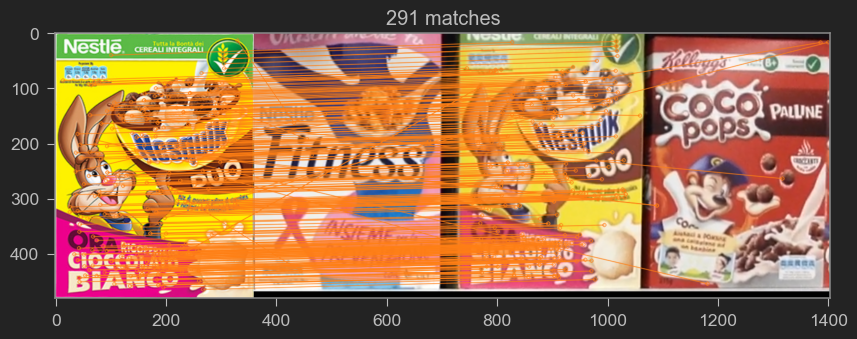

In [28]:
w,h,dpi = 1000, 400, 100
fig, ax = plt.subplots(figsize = (w/dpi, h/dpi), dpi = dpi)

im1 = cv2.drawMatches(im_model, kp1, im_scene, kp2, matches, None,
                       matchColor = Colors.ORANGE,
                       singlePointColor = None,
                       flags = 2)

ax.set_title(f"{len(matches)} matches")
ax.imshow(im1)
plt.show()

## Compute homography between the matching keypoints using the RANSAC method.

In [29]:
src_pts = np.float32([kp1[m.queryIdx].pt for m in matches])
dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches])

M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)


Plot bounding box of the model onto the scene

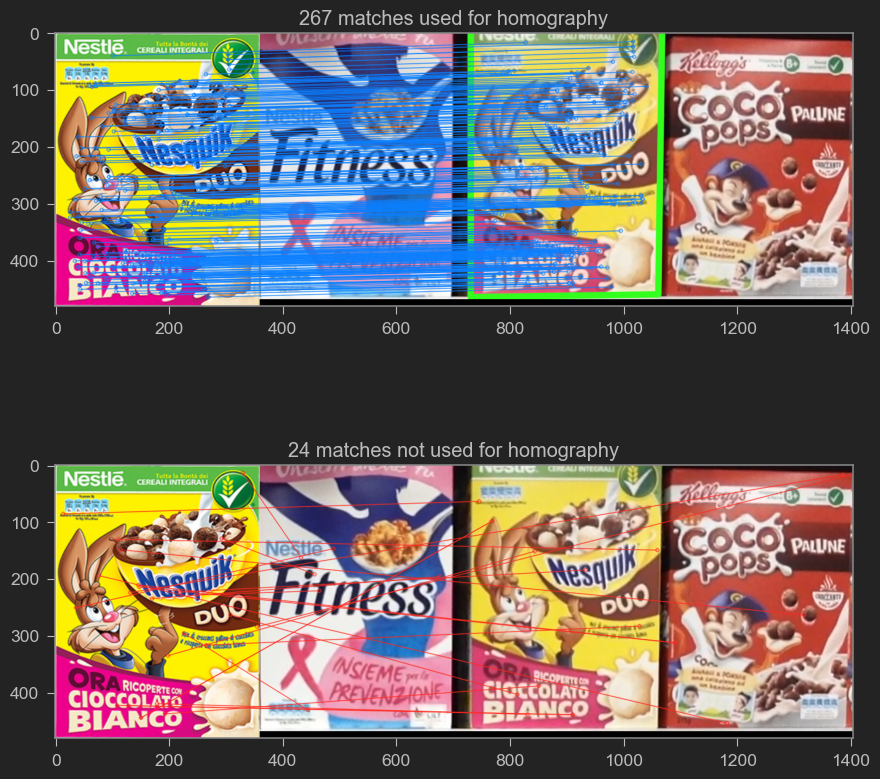

In [30]:
#draw bounding box
h, w = im_model.shape[0], im_model.shape[1]
pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)

# Projecting the corners into the train image
dst = cv2.perspectiveTransform(pts, M)

# Drawing the bounding box
im_bb = cv2.polylines(np.copy(im_scene), [np.int32(dst)], True, Colors.GREEN, 10, cv2.LINE_AA)


# matches used for the homography
im1 = cv2.drawMatches(im_model, kp1, im_bb, kp2, matches, None,
                       matchColor = Colors.BLUE,
                       singlePointColor = None,
                       matchesMask = mask.ravel().tolist(),
                       flags = 2)

# matches not used for the homography
im2 = cv2.drawMatches(im_model, kp1, im_scene, kp2, matches, None,
                       matchColor = Colors.RED,
                       singlePointColor = None,
                       matchesMask = (1-mask).ravel().tolist(),
                       flags = 2)


w, h, dpi = 900, 900, 100
fig, axs = plt.subplots(nrows = 2, figsize = (w/dpi, h/dpi), dpi = dpi)

axs[0].imshow(im1)
axs[0].set_title(f"{len(mask[mask==1])} matches used for homography")

axs[1].imshow(im2)
axs[1].set_title(f'{len(mask[mask==0])} matches not used for homography')

fig.tight_layout()

plt.show()


# Multiple Instance Detection (Step B and C)
This section explains the steps that the ``MultipleInstanceMatcher`` class performs to separate multiple instances of the same model in the scene image.

## Read images

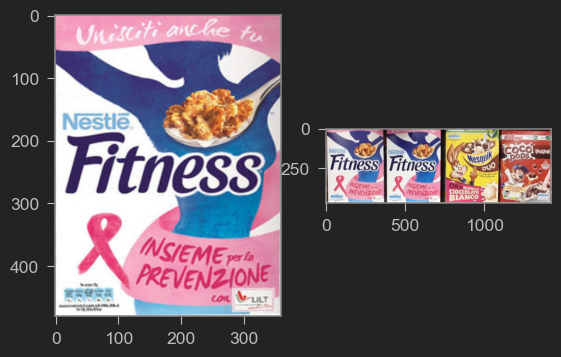

In [31]:
im_scene = cv2.cvtColor(cv2.imread(scene_folder + 'm1.png'), cv2.COLOR_BGR2RGB)
im_model = cv2.cvtColor(cv2.imread(model_folder + '24.jpg'), cv2.COLOR_BGR2RGB)

im_model = cv2.resize(im_model, (360, 480))

fig, axs = plt.subplots(ncols = 2)

axs[0].imshow(im_model)
axs[1].imshow(im_scene)
plt.show()

Display matches

Matches: 218


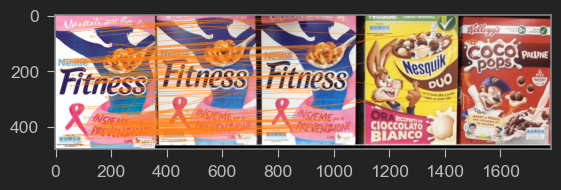

In [32]:
matcher = FeatureMatcher(im_model, im_scene)
matcher.set_match_distance_threshold(0.7)
matcher.find_matches()

kp_model, kp_scene = matcher.get_keypoints()
matches = matcher.get_matches()
print(f'Matches: {len(matches)}')

#display matching keypoints
im1 = cv2.drawMatches(im_model, kp_model, im_scene, kp_scene, matches, None,
                       matchColor = Colors.ORANGE,
                       singlePointColor = None,
                       flags = 2)

plt.imshow(im1)
plt.show()

## Generalized Hough transform

Calculate r-vectors

In [33]:
#filter keypoints that match (must do it after cv2.drawMatches)
kp_model = [kp_model[i] for i in [m.queryIdx for m in matches]]
kp_scene = [kp_scene[i] for i in [m.trainIdx for m in matches]]

#calculate r vectors for the model image
kp_model_pos = np.asarray([k.pt for k in kp_model])
kp_scene_pos = np.asarray([k.pt for k in kp_scene])

kp_model_angle = np.asarray([k.angle for k in kp_model])
kp_scene_angle = np.asarray([k.angle for k in kp_scene])
theta = (kp_scene_angle - kp_model_angle)*np.pi/180

kp_model_size = np.asarray([k.size for k in kp_model])
kp_scene_size = np.asarray([k.size for k in kp_scene])
s = kp_scene_size/kp_model_size

barycenter_model = np.mean(kp_model_pos, axis = 0)

r_vectors = barycenter_model - kp_model_pos

Rotate and scale the r-vectors in the scene and cast the votes

In [34]:
#convert the relative rotation of the keypoints in array of rotation matrices
rotmats = np.array([[np.cos(theta), -np.sin(theta)],
                   [np.sin(theta), np.cos(theta)]])
rotmats = np.moveaxis(rotmats, (2,0,1), (0,1,2))

In [35]:
#rotate the r vectors according to their corresponding rotation matrix
r_vectors_rotated = rotmats@np.expand_dims(r_vectors, axis = -1)
r_vectors_rotated = r_vectors_rotated.squeeze()

#r_vectors_rotated = r_vectors
#scale the rotated vectors according to their corresponding scale
r_vectors_scaled = np.multiply(r_vectors_rotated, np.expand_dims(s, axis = -1))

#vote the positions of the barycenter and 
vote_pos = kp_scene_pos + r_vectors_scaled
vote_pos = np.rint(vote_pos).astype(int)

#discard votes outside of the image frame
vote_inside_mask = (vote_pos[:,0] < im_scene.shape[1]) & (vote_pos[:,1] < im_scene.shape[0]) & (vote_pos[:,0] >= 0) & (vote_pos[:,1] >= 0)
vote_pos = vote_pos[vote_inside_mask]
kp_model_pos = kp_model_pos[vote_inside_mask]
kp_scene_pos = kp_scene_pos[vote_inside_mask]

Compute accumulator array

In [36]:
K = 15
n_bins = im_scene.shape[1]//K
m_bins = im_scene.shape[0]//K
acc_bin = np.zeros((n_bins, m_bins))

for pos in vote_pos:
    i,j = pos//K

    #discard votes outside of the image frame
    if i>=n_bins or j>=m_bins or i<0 or j<0: continue

    acc_bin[i,j]+=1

sigma = 0
k = np.ceil(3*sigma).astype(int)
acc_bin = cv2.GaussianBlur(acc_bin, (2*k+1,2*k+1), sigma)

#norm = np.linalg.norm(acc_bin)
acc_bin = acc_bin / np.max(acc_bin)

## Cluster the votes in the vote space

Find peaks in accumulator

In [37]:
x = acc_bin.flatten()

peaks_1d, _ = find_peaks(x, height=0.3, distance = 0.05*im_scene.shape[0]*im_scene.shape[1]/K**2)

peaks = np.vstack(np.unravel_index(peaks_1d, acc_bin.shape))*K
peaks = peaks.T

Display peaks

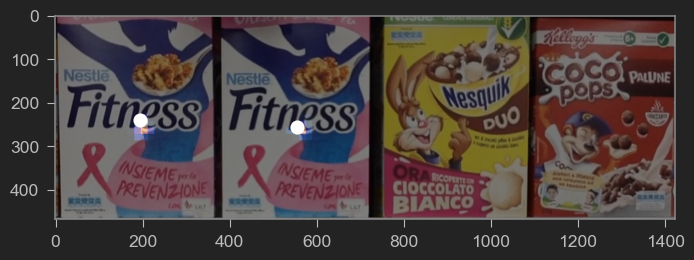

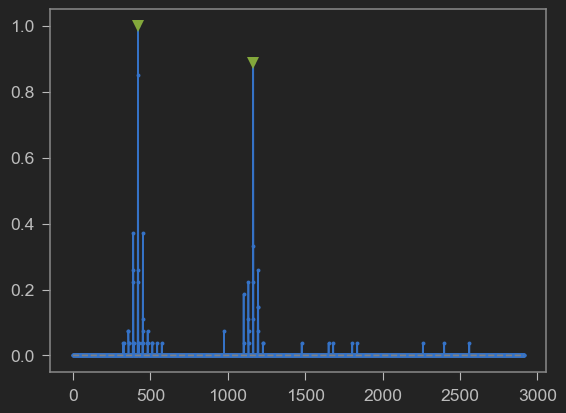

In [38]:
w, h, dpi = 800, 600, 100
fig, ax = plt.subplots(figsize = (w/dpi,h/dpi), dpi = dpi)

w, h = im_scene.shape[0], im_scene.shape[1]
acc_bin_resized = cv2.resize(acc_bin.astype(np.float32), (w, h), interpolation=cv2.INTER_NEAREST)
ax.imshow(acc_bin_resized.T, cmap=cmr.get_sub_cmap(cmr.torch, 0, 0.9))
ax.imshow(im_scene, alpha=0.5)
ax.scatter(peaks[:,0], peaks[:,1], color = 'w', s = 100)

plt.show()

plt.plot(x, '.-')
plt.plot(peaks_1d, x[peaks_1d], "v", markersize = 8)

plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()


Assign label to each keypoint

In [39]:
#initialize array of distances. First axis for the peak, second axis for the keypoint
#so the shape is (num_peaks, num_keypoints) 
n_votes = vote_pos.shape[0]
n_peaks = peaks.shape[0]

distances = np.zeros((n_peaks, n_votes, ))

for i, peak in enumerate(peaks):
    distances[i] = np.linalg.norm(vote_pos - peak.T, axis = 1)

predicted_labels = np.argmin(distances, axis = 0)

Display labeled votes

Cluster 0 size: 124
Cluster 1 size: 89


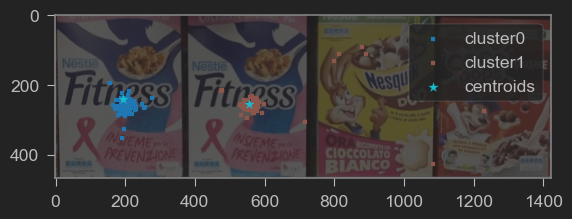

In [40]:
for label in np.unique(predicted_labels):
    print(f"Cluster {label} size: {len(vote_pos[predicted_labels==label])}")

plt.imshow(im_scene, alpha = 0.25)

plot_clusters(vote_pos, predicted_labels, dim=(0,1), points = peaks)

Display bounding box

In [41]:
MIN_CLUSTER_THRESHOLD = 15

Homographies = []

for label in np.unique(predicted_labels):
    label_mask = predicted_labels==label
    votes = vote_pos[label_mask]
    if label==-1 or len(votes) < MIN_CLUSTER_THRESHOLD: continue

    kp_model_filtered = kp_model_pos[label_mask]
    kp_scene_filtered = kp_scene_pos[label_mask]

    M, mask = cv2.findHomography(kp_model_filtered, kp_scene_filtered, cv2.RANSAC, 1.)
    Homographies.append(M)

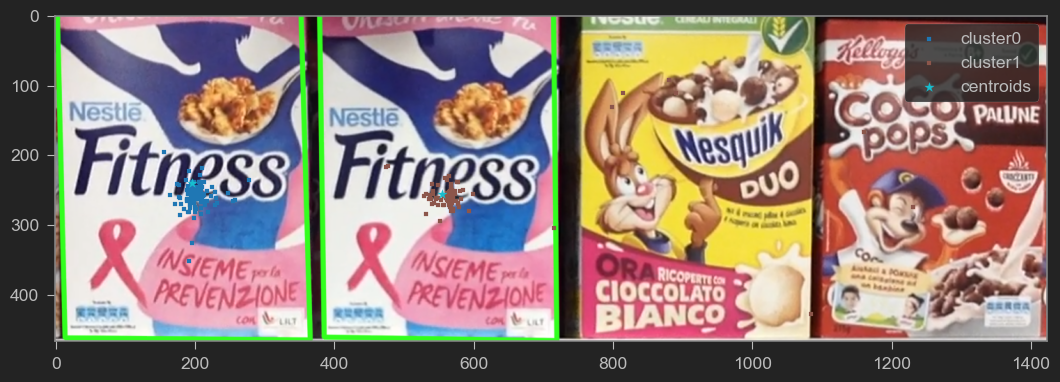

In [42]:
w, h, dpi = 1280, 720, 100
fig, ax = plt.subplots(figsize= (w/dpi, h/dpi), dpi=dpi)

im2 = np.copy(im_scene)

for M in Homographies:

    h, w = im_model.shape[0], im_model.shape[1]
    pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)

    # Projecting the corners into the train image
    dst = cv2.perspectiveTransform(pts, M)
    im2 = cv2.polylines(im2, [np.int32(dst)], True, Colors.GREEN, 5, cv2.LINE_AA)

plot_clusters(vote_pos, predicted_labels, dim=(0,1), points = peaks)
plt.imshow(im2)

plt.show()
